In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# %%
class MARL:
    def __init__(self, states, actions, rewards, gamma=0.99):
        self.gamma = gamma
        self.states = states
        self.actions = actions
        self.rewards = rewards

        self.transition = dict()
        for action in actions:
            self.transition[action] = np.zeros((len(states), len(states)))

        self.optimal_value = np.zeros((len(states)))
        self.policy = [actions[0] for _ in states]  # Initialize a random policy

    def update_transition(self, action, state, next_state, probability):
        self.transition[action][self.states.index(state), self.states.index(next_state)] = probability

    def value_iteration(self):
        while True:
            temp_value = self.optimal_value.copy()
            for i, state in enumerate(self.states):
                temp = list()
                for action in self.actions:
                    temp.append(np.dot(self.transition[action][i], self.optimal_value.T))

                self.optimal_value[i] = self.rewards[i] + self.gamma * np.max(temp)

            if np.array_equal(temp_value, self.optimal_value):
                print("Optimal Value:")
                res = "\n".join("{} {}".format(x, y) for x, y in zip(self.states, self.optimal_value))
                print(res)

                print("Optimal Policy")
                optimal_policy = list()
                for i, state in enumerate(self.states):
                    temp = list()
                    for action in self.actions:
                        temp.append(np.dot(self.transition[action][i], self.optimal_value.T))
                    optimal_policy.append(self.actions[np.argmax(temp)])
                res = "\n".join("{} {}".format(x, y) for x, y in zip(self.states, optimal_policy))
                print(res)

                return self.policy

    def policy_evaluation(self):
        """
        Perform policy evaluation: Update the value function for a given policy.
        """
        while True:
            temp_value = self.optimal_value.copy()
            for i, state in enumerate(self.states):
                action = self.policy[i]
                self.optimal_value[i] = self.rewards[i] + self.gamma * np.dot(self.transition[action][i], self.optimal_value.T)

            if np.array_equal(temp_value, self.optimal_value):
                break

    def policy_improvement(self):
        """
        Perform policy improvement: Update the policy based on the current value function.
        """
        policy_stable = True
        for i, state in enumerate(self.states):
            old_action = self.policy[i]
            action_values = []

            for action in self.actions:
                action_value = np.dot(self.transition[action][i], self.optimal_value.T)
                action_values.append(action_value)

            best_action = self.actions[np.argmax(action_values)]
            self.policy[i] = best_action

            if old_action != best_action:
                policy_stable = False

        return policy_stable

    def policy_iteration(self):
        """
        Perform policy iteration: Iteratively evaluate and improve the policy until it is stable.
        """
        while True:
            self.policy_evaluation()
            if self.policy_improvement():
                print("Optimal Value:")
                res = "\n".join("{} {}".format(x, y) for x, y in zip(self.states, self.optimal_value))
                print(res)
                print("Optimal Policy Found:")
                res = "\n".join("{} {}".format(x, y) for x, y in zip(self.states, self.policy))
                print(res)
                break

        return self.policy

In [27]:

a = np.empty((9, 9), dtype=str)
a.fill("E")
a[0, 0] = 'S'
a[1:4, 3] = "N"
a[3, 1:4] = "N"
a[5:, 5] = "N"
a[5, 5:] = "N"
a[-1, -1] = "G"
a[2, 2] = "I"
a[6, 6] = "O"
a


states = []
for i in range(9):
    for j in range(9):
        states.append((i, j))

rewards = [0] * len(states)
rewards[-1] = 1  # Reward at the goal state

def update_transition(xx):
    for i in range(8):
        for j in range(9):
            if a[i, j] != "N" and a[i+1, j] != "N":
                xx.update_transition('up', (i, j), (i+1, j), 1)

    for i in range(8, 0, -1):
        for j in range(9):
            if a[i, j] != "N" and a[i-1, j] != "N":
                xx.update_transition('down', (i, j), (i-1, j), 1)

    for i in range(9):
        for j in range(0, 8):
            if a[i, j] != "N" and a[i, j+1] != "N":
                xx.update_transition('right', (i, j), (i, j+1), 1)

    for i in range(9):
        for j in range(8, 0, -1):
            if a[i, j] != "N" and a[i, j-1] != "N":
                xx.update_transition('left', (i, j), (i, j-1), 1)

    xx.update_transition('down', (2, 2), (6, 6), 1)
    xx.update_transition('down', (2, 2), (1, 2), 0)
    xx.update_transition('left', (2, 2), (2, 1), 0)
    xx.update_transition('left', (2, 2), (6, 6), 1)
    xx.update_transition('down', (8, 8), (7, 8), 0)
    xx.update_transition('left', (8, 8), (8, 7), 0)


In [23]:

def plot(optimal_policy, rl_env):
    # Grid size
    grid_size = (9, 9)

    # Initialize grid (0: empty, 1: obstacle, 2: tunnel, 3: start, 4: end)
    grid = np.zeros(grid_size, dtype=int)

    # Define some obstacles
    obstacles = [(3, 1), (3, 2), (3, 3), (2, 3), (1, 3), 
                (8, 5), (7, 5), (6, 5), (5, 5), (5, 6), (5, 7), (5, 8)]
    for (x, y) in obstacles:
        grid[x, y] = 1

    tunnel_in = (2, 2)
    tunnel_out = (6, 6)

    # Define start and end cells
    start = (0, 0)
    end = (8, 8)
    grid[start] = 3
    grid[end] = 4

    # Set up the figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create quiver plot data
    X, Y = np.meshgrid(np.arange(grid_size[1]), np.arange(grid_size[0]))
    U = np.zeros_like(X, dtype=float)
    V = np.zeros_like(Y, dtype=float)

    # Direction vectors for 'up', 'down', 'left', 'right'
    directions = {
        'up': (0, 1),
        'down': (0, -1),
        'left': (-1, 0),
        'right': (1, 0)
    }
    for i in range(9):
        for j in range(9):
            policy = optimal_policy[rl_env.states.index((i, j))]
            ax.quiver(j, i, directions[policy][0], directions[policy][1])

    for (x, y) in obstacles:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, color='black'))

    ax.plot(start[1], start[0], 'go', markersize=10, label='Start')
    ax.plot(end[1], end[0], 'ro', markersize=10, label='End')
    ax.plot(tunnel_in[1], tunnel_in[0], color='orange', marker='o', markersize=10, label='IN')
    ax.plot(tunnel_out[1], tunnel_out[0], color='blue', marker='o', markersize=10, label='OUT')

    ax.set_xticks(np.arange(-0.5, grid_size[1], 1))
    ax.set_yticks(np.arange(-0.5, grid_size[0], 1))
    ax.grid(color='gray', linestyle='-', linewidth=0.5)
    ax.set_xlim([-0.5, grid_size[1] - 0.5])
    ax.set_ylim([-0.5, grid_size[0] - 0.5])
    ax.set_aspect('equal')
    ax.legend()

    plt.show()



Optimal Value:
(0, 0) 0.9135172474836407
(0, 1) 0.92274469442792
(0, 2) 0.9320653479069899
(0, 3) 0.92274469442792
(0, 4) 0.9135172474836407
(0, 5) 0.9043820750088043
(0, 6) 0.8953382542587163
(0, 7) 0.8863848717161291
(0, 8) 0.8775210229989678
(1, 0) 0.92274469442792
(1, 1) 0.9320653479069899
(1, 2) 0.9414801494009999
(1, 3) 0.0
(1, 4) 0.9043820750088043
(1, 5) 0.8953382542587163
(1, 6) 0.8863848717161291
(1, 7) 0.8775210229989678
(1, 8) 0.8687458127689781
(2, 0) 0.9320653479069899
(2, 1) 0.9414801494009999
(2, 2) 0.9509900498999999
(2, 3) 0.0
(2, 4) 0.8953382542587163
(2, 5) 0.8863848717161291
(2, 6) 0.8775210229989678
(2, 7) 0.8687458127689781
(2, 8) 0.8600583546412883
(3, 0) 0.92274469442792
(3, 1) 0.0
(3, 2) 0.0
(3, 3) 0.0
(3, 4) 0.8863848717161291
(3, 5) 0.8775210229989678
(3, 6) 0.8687458127689781
(3, 7) 0.8600583546412883
(3, 8) 0.8514577710948754
(4, 0) 0.9135172474836407
(4, 1) 0.9043820750088043
(4, 2) 0.8953382542587163
(4, 3) 0.8863848717161291
(4, 4) 0.8775210229989678
(4

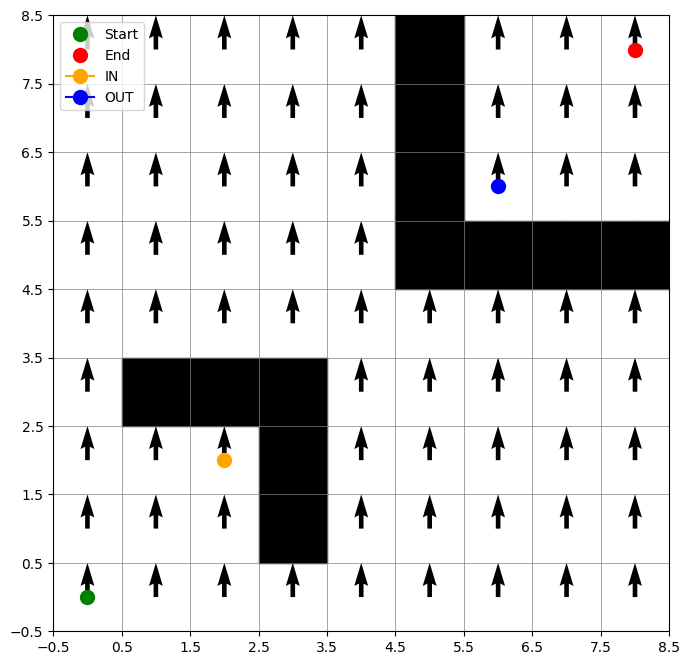

In [24]:

# ## Value Iteration

# %%
rl_env = MARL(states=states, actions=['up', 'down', 'left', 'right'], rewards=rewards)
update_transition(rl_env)

optimal_policy_vi = rl_env.value_iteration()
plot(optimal_policy_vi, rl_env)


Optimal Value:
(0, 0) 0.9135172474836407
(0, 1) 0.92274469442792
(0, 2) 0.9320653479069899
(0, 3) 0.92274469442792
(0, 4) 0.9135172474836407
(0, 5) 0.9043820750088043
(0, 6) 0.8953382542587163
(0, 7) 0.8863848717161291
(0, 8) 0.8775210229989678
(1, 0) 0.92274469442792
(1, 1) 0.9320653479069899
(1, 2) 0.9414801494009999
(1, 3) 0.0
(1, 4) 0.9043820750088043
(1, 5) 0.8953382542587163
(1, 6) 0.8863848717161291
(1, 7) 0.8775210229989678
(1, 8) 0.8687458127689781
(2, 0) 0.9320653479069899
(2, 1) 0.9414801494009999
(2, 2) 0.9509900498999999
(2, 3) 0.0
(2, 4) 0.8953382542587163
(2, 5) 0.8863848717161291
(2, 6) 0.8775210229989678
(2, 7) 0.8687458127689781
(2, 8) 0.8600583546412883
(3, 0) 0.92274469442792
(3, 1) 0.0
(3, 2) 0.0
(3, 3) 0.0
(3, 4) 0.8863848717161291
(3, 5) 0.8775210229989678
(3, 6) 0.8687458127689781
(3, 7) 0.8600583546412883
(3, 8) 0.8514577710948754
(4, 0) 0.9135172474836407
(4, 1) 0.9043820750088043
(4, 2) 0.8953382542587163
(4, 3) 0.8863848717161291
(4, 4) 0.8775210229989678
(4

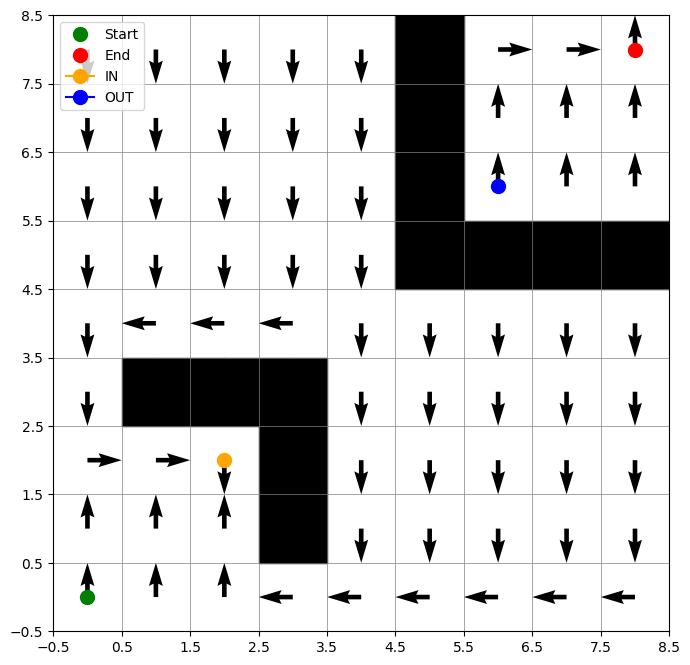

In [22]:
# %% [markdown]
# ## Policy Iteration

# %%
rl_env = MARL(states=states, actions=['up', 'down', 'left', 'right'], rewards=rewards)
update_transition(rl_env)

optimal_policy_pi = rl_env.policy_iteration()
plot(optimal_policy_pi, rl_env)